# Table of Contents
[1. Data Importation & Cleaning](#1---data-importation)
- [1.1 - Relevant imports](#relevant-imports)
- [1.2 - Importing the datasets](#importing-the-datasets)
- [1.3 - Reaarangements & new columns](#rearrangements)
- [1.4 - Data cleaning](#data-cleaning)

[2. Exploratory Data Analysis](#2---exploratory-data-analysis)
- [2.1 Visualizing categorical & numerical variables](#visualizing-categorical--numerical-variables)
- [2.2 Visualizing numerical variables]()
- [2.3 Insights]()

[3. Machine Learning](#3---machine-learning)
- [3.1 - Classification Models](#classification-models)
    - [3.1.1 - Random Forest Classifier](#)
    - [3.1.2 - Support Vector Machine Classifier](#)
    - [3.1.3 - eXtreme Gradient Boosting Classifier](#)
    - [3.1.4 - Hyperparameter Tuning]()
        - [GridSearch]()
        - [RandomSearch]()
- [3.2 - Regression Models](#regression-models)
    - [3.1.1 - eXtreme Gradient Boosting Regressor](#)
    - [3.1.2 - gplearn Symbolic Regressor](#)
    -

## 1 - Data Importation

#### Relevant imports

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Importing the datasets

In [96]:
dataset1, dataset2, dataset3, dataset4, dataset5 = pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([]), pd.DataFrame([])

data_list = [dataset1, dataset2, dataset3, dataset4, dataset5]

for a in range(0, 5):
    file_path="data/dataset"+str(a+1)+".csv"
    data_list[a] = pd.read_csv(file_path)

# for a in range(0, len(data_list)):
#    data_list[a].info()


for df in data_list:
    if 'Inclination angle (deg)' in df.columns:
        df.columns = ['Well No.', 'G (m3/d)', 'P1 (MPa)', 'P2 (MPa)', 'T1 (degC)', 'T2 (degC)', 'ID (mm)', 'inc (deg)', 'h (m)', 'Loading status']
        df.set_index("Well No.", inplace=True)
        
    else:
        df.columns = ['Well No.', 'G (m3/d)', 'P1 (MPa)', 'P2 (MPa)', 'T1 (degC)', 'T2 (degC)', 'ID (mm)', 'h (m)', 'Loading status']
        df.set_index("Well No.", inplace=True)

dataset = pd.DataFrame([])

dataset = pd.concat([df for df in data_list]).reset_index(drop=True).rename_axis('Well No.')
# Check the dataset
# dataset.info()
dataset.describe(include='all')

dataset.to_csv('data/dataset_unclean.csv')

In [97]:
dataset['G (m3/d)'] = dataset['G (m3/d)'].astype(float)
dataset['Loading status'] = dataset['Loading status'].str.strip().astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   G (m3/d)        263 non-null    float64 
 1   P1 (MPa)        106 non-null    float64 
 2   P2 (MPa)        263 non-null    float64 
 3   T1 (degC)       56 non-null     float64 
 4   T2 (degC)       85 non-null     float64 
 5   ID (mm)         140 non-null    float64 
 6   h (m)           158 non-null    float64 
 7   Loading status  263 non-null    category
 8   inc (deg)       105 non-null    float64 
dtypes: category(1), float64(8)
memory usage: 17.0 KB


### Rearrangements

The following code:
- imputes missing values for internal diameter using the modal value, since internal diameter is a fixed, constant and precalculated value
- imputes missing values for wellbore pressure using the average pressure difference from rows that have both wellbore and wellhead pressure data
- imputes missing values for well depth using the average value
- creates new columns for
    - pressure difference (delta_P, MPa) - P1 - P2
    - pressure gradient (P_grad, MPa/m) - $\frac{delta\_P}{h}$
    - cross-sectional area of well $(CSA, m^2) = {\pi}*(\frac{ID}{2})^2$, converted to relevant units
    - superficial velocity (sup_v, m/s) - $\frac{G}{A}$, converted to relevant units
- corrects column types

In [98]:
# Impute missing values for ID (mm)
dataset["ID (mm)"] = dataset["ID (mm)"].fillna(value=dataset["ID (mm)"].mode().iloc[0])

# Impute missing values for P1 (MPa)
dataset_temp_1 = dataset.dropna(subset=['P1 (MPa)'])
avg_p_diff = (dataset_temp_1['P1 (MPa)'] - dataset_temp_1['P2 (MPa)']).mean()
dataset["P1 (MPa)"] = dataset["P1 (MPa)"].fillna((dataset['P2 (MPa)'] + avg_p_diff))

# Impute missing values for h (m)
dataset_temp_2 = dataset.dropna(subset=['h (m)'])
avg_h = dataset_temp_2['h (m)'].mean()
dataset['h (m)'] = dataset['h (m)'].fillna(avg_h)

# impute missing inc (deg)
dataset['inc (deg)'] = dataset['inc (deg)'].fillna(0)

# recompute vertical depths
dataset['h (m)'] = dataset['h (m)'] * np.cos(np.deg2rad(dataset['inc (deg)']))

# Update column ID (mm)
dataset['ID (m)'] = dataset['ID (mm)'] / 1000

# Create new column, delta_P
dataset['delta_P (MPa)'] = np.abs(dataset['P1 (MPa)'] - dataset['P2 (MPa)'])

# Create new column, P_grad
dataset['P_grad (MPa / m)'] = dataset['delta_P (MPa)'] / dataset['h (m)']

dataset['T2 (degC)'] = dataset['T2 (degC)'].fillna(dataset['T2 (degC)'].mean())
dataset['T1 (degC)'] = dataset['T1 (degC)'].fillna(dataset['T1 (degC)'].mean())

# Create new column, delta_T
dataset['delta_T (degC)'] = np.abs(dataset['T1 (degC)'] - dataset['T2 (degC)'])

# Create new column, T_grad
dataset['T_grad (degC / m)'] = dataset['delta_T (degC)'] / dataset['h (m)']

# Create new column, CSA (m2)
dataset['CSA (m2)'] = dataset['ID (mm)'].apply(lambda x: np.pi * (x/2000)**2)

# Create new column, sup_v (m/s)
dataset['sup_v (m/s)'] = dataset['G (m3/d)'] / (dataset['CSA (m2)'] * 24 * 3600)

# Adjust type of col 'Loading status'
dataset['Loading status'] = dataset['Loading status'].str.strip().astype('category')
dataset["Loading status"] = dataset['Loading status'].cat.set_categories(["Unloaded", "Near Load Up", "Loaded Up"], ordered=True)

# print(dataset['Loading status'].value_counts(dropna=False))
dataset = dataset[['G (m3/d)', 'CSA (m2)', 'P1 (MPa)', 'P2 (MPa)', 'P_grad (MPa / m)', 'T1 (degC)', 'T2 (degC)', 'T_grad (degC / m)', 'ID (m)', 'sup_v (m/s)', 'Loading status']]

# Check dataset
dataset.info()
dataset.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   G (m3/d)           263 non-null    float64 
 1   CSA (m2)           263 non-null    float64 
 2   P1 (MPa)           263 non-null    float64 
 3   P2 (MPa)           263 non-null    float64 
 4   P_grad (MPa / m)   263 non-null    float64 
 5   T1 (degC)          263 non-null    float64 
 6   T2 (degC)          263 non-null    float64 
 7   T_grad (degC / m)  263 non-null    float64 
 8   ID (m)             263 non-null    float64 
 9   sup_v (m/s)        263 non-null    float64 
 10  Loading status     263 non-null    category
dtypes: category(1), float64(10)
memory usage: 21.1 KB


,G (m3/d),CSA (m2),P1 (MPa),P2 (MPa),P_grad (MPa / m),T1 (degC),T2 (degC),T_grad (degC / m),ID (m),sup_v (m/s),Loading status
count,263.000000,263.000000,263.000000,263.000000,2.630000e+02,263.000000,263.000000,2.630000e+02,263.000000,263.000000,263
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loaded Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,178
mean,82527.050989,0.003683,15.527154,8.690456,8.577786e+11,96.843571,37.950588,1.014318e+13,0.064909,321.807087,NaN
std,97826.654601,0.003909,17.560292,9.071457,6.173441e+12,13.598733,10.970754,7.300059e+13,0.021849,388.801023,NaN
min,1200.000000,0.001521,0.840000,0.300000,5.711768e-05,40.000000,16.000000,9.379716e-04,0.044000,4.600386,NaN
25%,16816.140000,0.003019,7.436698,1.375000,1.726897e-03,96.843571,37.950588,2.290246e-02,0.062000,64.467275,NaN
50%,48466.720000,0.003019,11.000000,4.600000,3.000830e-03,96.843571,37.950588,2.683720e-02,0.062000,174.408940,NaN
75%,116976.900000,0.003019,20.821698,14.450000,4.390055e-03,96.843571,37.950588,3.489128e-02,0.062000,456.204914,NaN


### Data cleaning

#### Observations
- a row of data was observed with 0 gas flowrate.  on closer observation, its wellhead pressure was also about 0.6 MPa. As such, calculated values like sup_v were also 0. The well was also marked as `Loaded Up`. This row of data is valid and would be left in the final dataset.
- Wellhead pressure had an extremely high value that should be removed as it significantly skews the mean and median

In [99]:
print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['P1 (MPa)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['G (m3/d)'])
# print(dataset.loc[dataset['P1 (MPa)'].idxmax()]['sup_v (m/s)'])
# print("P1 stats before clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())
dataset.drop(index=dataset['P1 (MPa)'].idxmax(), inplace=True)
dataset.drop(index=dataset['T_grad (degC / m)'].idxmax(), inplace=True)
dataset.drop(index=dataset['T_grad (degC / m)'].idxmin(), inplace=True)
print("T_grad stats after clean (max, min, avg)", dataset['P1 (MPa)'].max(), dataset['P1 (MPa)'].min(), dataset['P1 (MPa)'].mean())
dataset.reset_index(drop=True, inplace=True)

# observations
print(dataset.loc[dataset['G (m3/d)'].idxmin()])

# Check dataset
dataset.info()
dataset.describe(include='all')

dataset.to_csv('data/dataset_clean.csv')

240.0
T_grad stats after clean (max, min, avg) 63.50669811320755 0.84 14.73336502177068
G (m3/d)                1200.0
CSA (m2)              0.003019
P1 (MPa)                  5.13
P2 (MPa)                  3.54
P_grad (MPa / m)      0.000784
T1 (degC)                 59.0
T2 (degC)            37.950588
T_grad (degC / m)     0.010384
ID (m)                   0.062
sup_v (m/s)           4.600386
Loading status       Loaded Up
Name: 172, dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   G (m3/d)           260 non-null    float64 
 1   CSA (m2)           260 non-null    float64 
 2   P1 (MPa)           260 non-null    float64 
 3   P2 (MPa)           260 non-null    float64 
 4   P_grad (MPa / m)   260 non-null    float64 
 5   T1 (degC)          260 non-null    float64 
 6   T2 (degC)          260 non-null    float64 


## 2 - Exploratory Data Analysis

### Visualising Categorical & Numerical Variables


(0.0, 1.0)

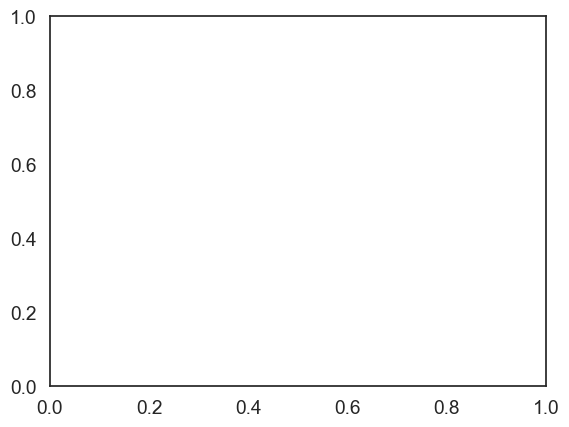

In [100]:
sns.set_palette('colorblind', 3)
sns.set(font_scale=1.25, style='white')
figsize = (26.88, 7.56)
plt.xlim(0, )
plt.ylim(0, )


197


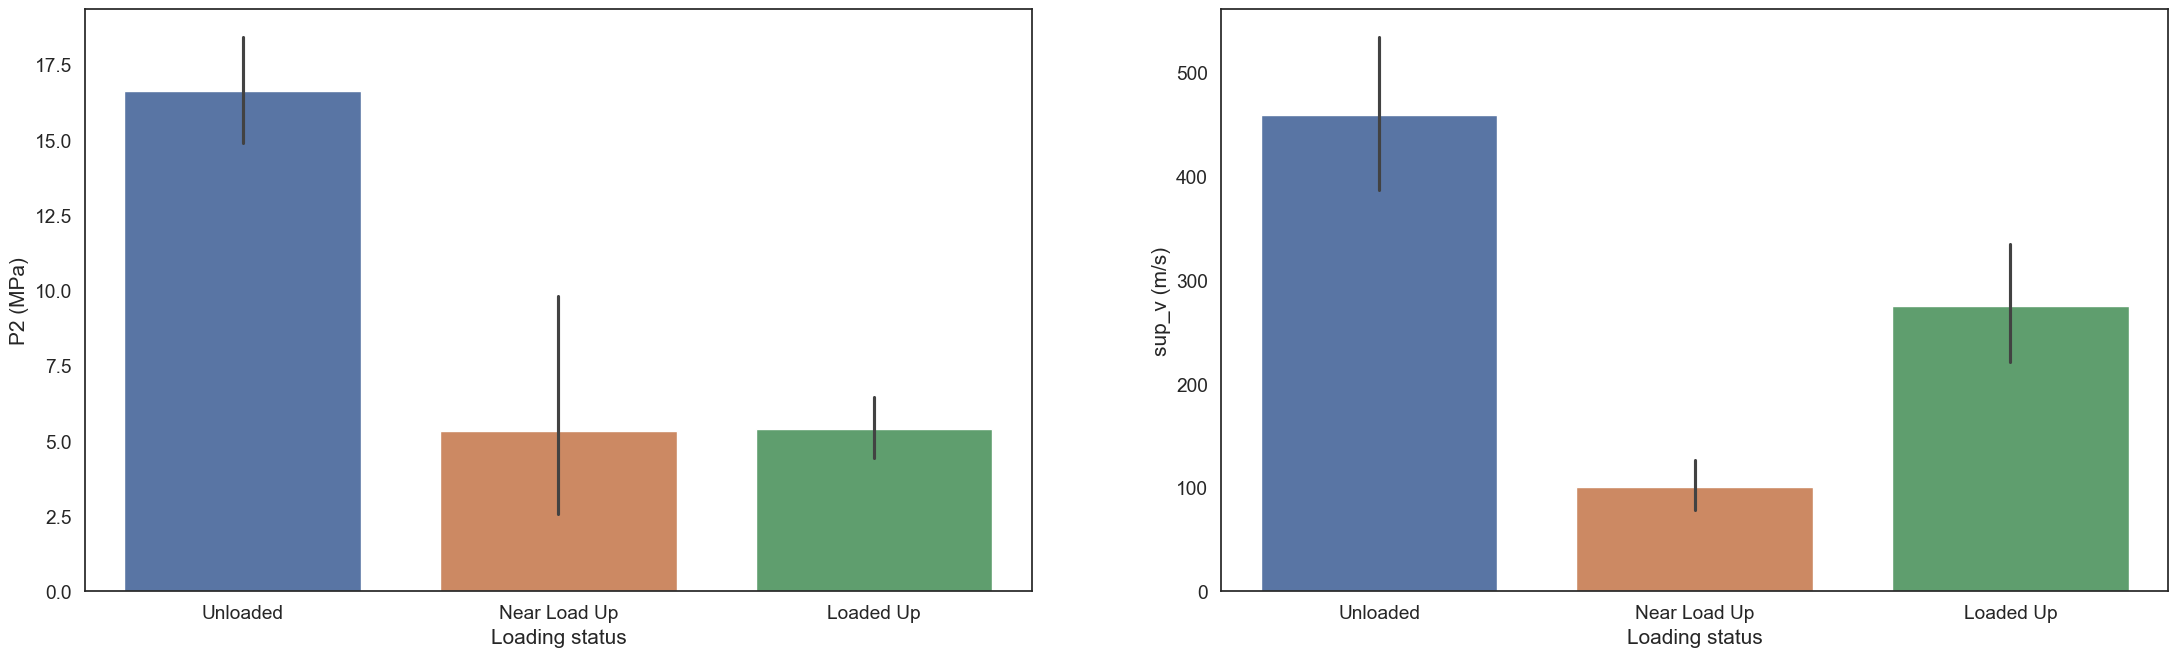

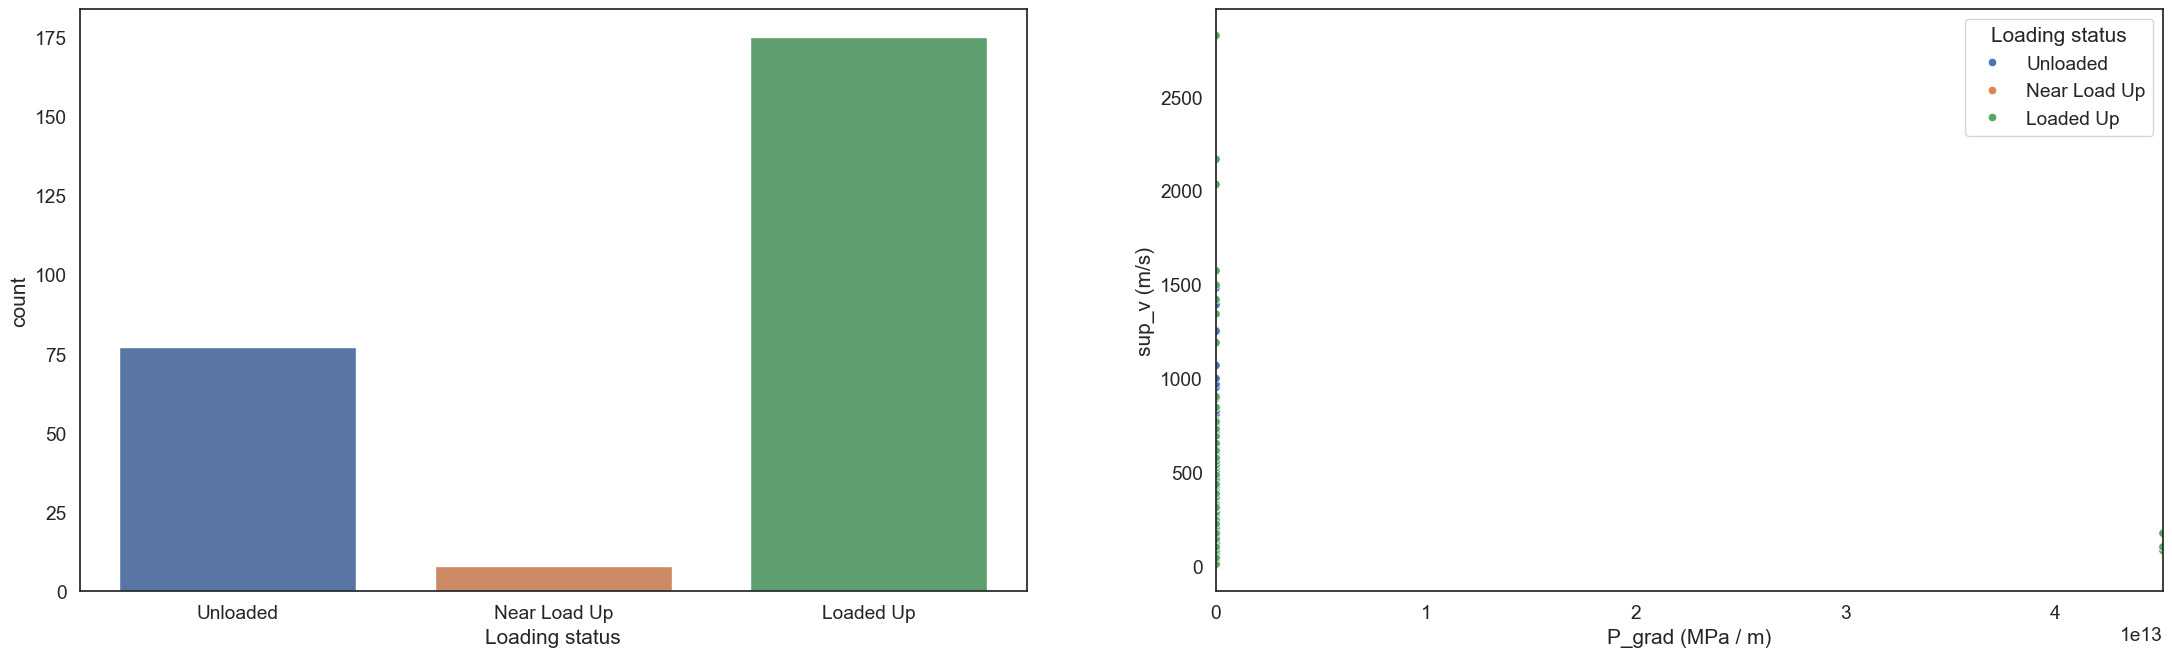

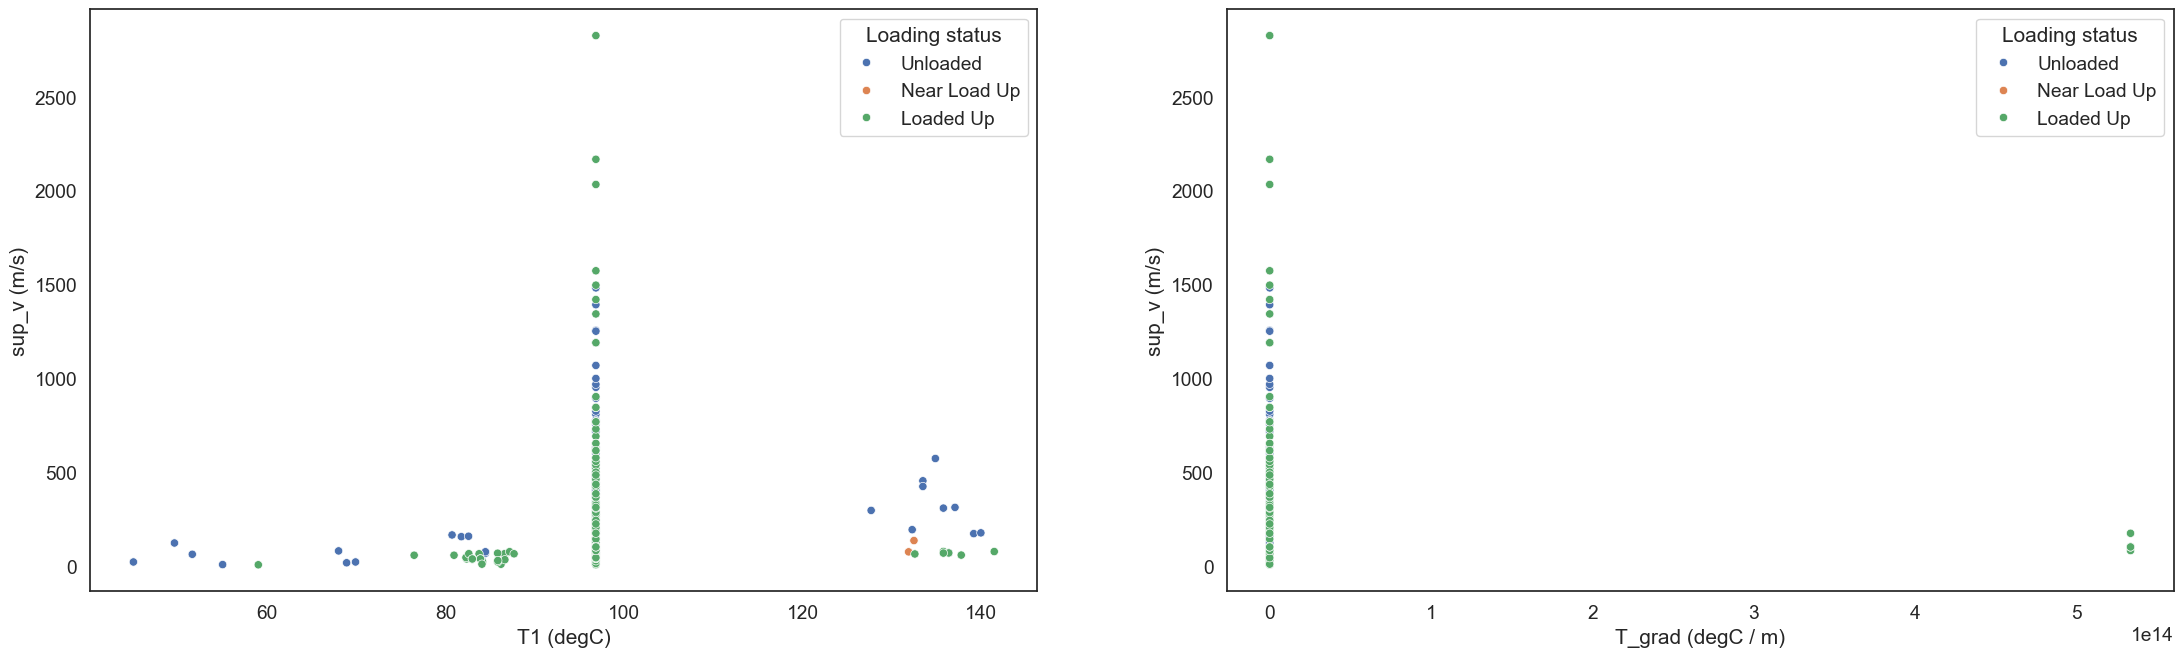

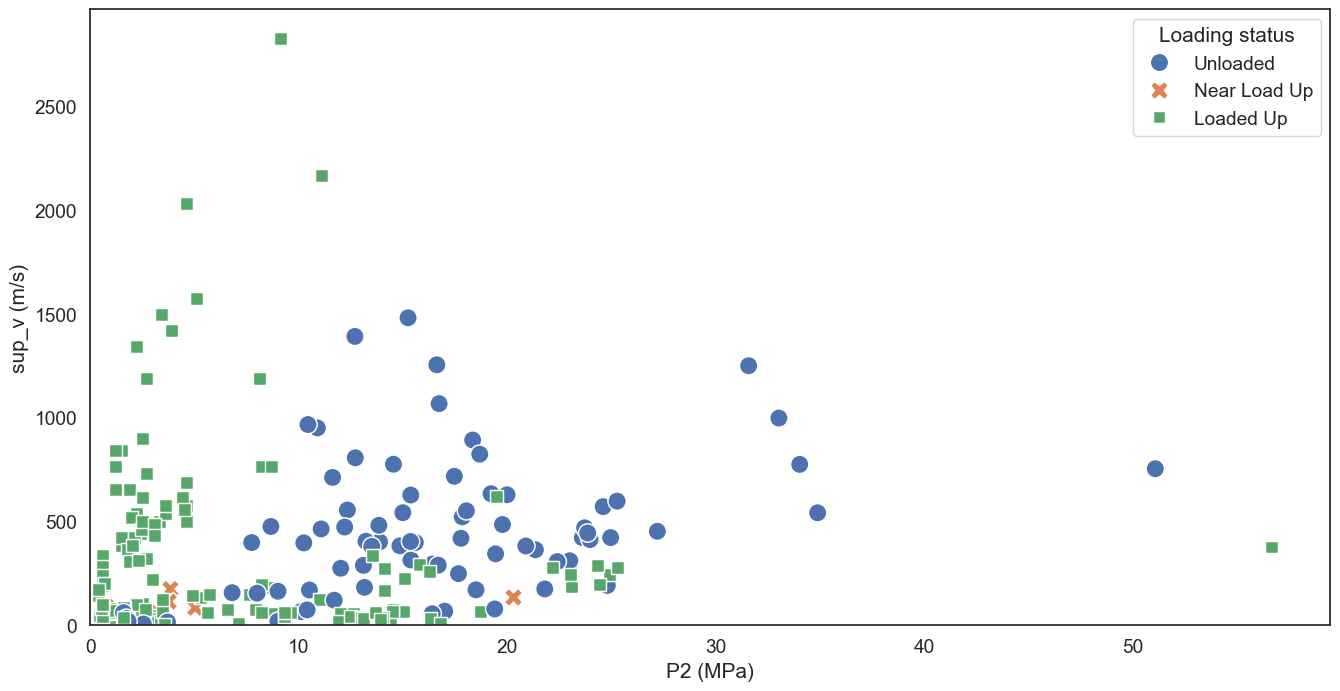

In [101]:
print(dataset['P_grad (MPa / m)'].nunique())
# Comparing average pressure and superficial vel. between categories
fig, axs = plt.subplots(1, 2, figsize=figsize)
sns.barplot(x='Loading status', y='P2 (MPa)', data=dataset, ax=axs[0], hue='Loading status', width=0.75)
sns.barplot(x='Loading status', y='sup_v (m/s)', data=dataset, ax=axs[1], hue='Loading status', width=0.75)

fig, axs = plt.subplots(1, 2, figsize=figsize)
sns.countplot(x='Loading status', data=dataset, ax=axs[0], hue='Loading status', width=0.75)
sns.scatterplot(dataset, x='P_grad (MPa / m)', y='sup_v (m/s)', ax=axs[1], hue='Loading status')
axs[1].set_xlim(0, dataset['P_grad (MPa / m)'].max())

fig, axs = plt.subplots(1, 2, figsize=figsize)
sns.scatterplot(dataset, x='T1 (degC)', y='sup_v (m/s)', ax=axs[0], hue='Loading status')
sns.scatterplot(dataset, x='T_grad (degC / m)', y='sup_v (m/s)', ax=axs[1], hue='Loading status')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.scatterplot(dataset, x='P2 (MPa)', y='sup_v (m/s)', hue='Loading status', ax=ax, style='Loading status', s=175)

plt.xlim(0, )
plt.ylim(0, )

plt.show()

The charts above show a distinct difference in the wellhead pressure and superficial velocity of loaded wells, near-loaded, and unloaded wells. In both the pressure and superficial velocity bar charts, the loaded and near-loaded wells show a significantly lower value than unloaded wells. The relational plot between wellhead pressure and superficial velocity shows us two major things:
- There is a positive correlation between wellhead pressure and superficial velocity. This holds true whether the well is loaded, near-loaded or unloaded.
- The unloaded wells have much higher values of both wellhead pressure and superficial velocity, while wells marked as near-loaded and loaded have lower values.

This reestablishes the idea that loading is due to a significant reduction in pressure, leading to a drop in superficial velocity

### Visualising Numerical Variables

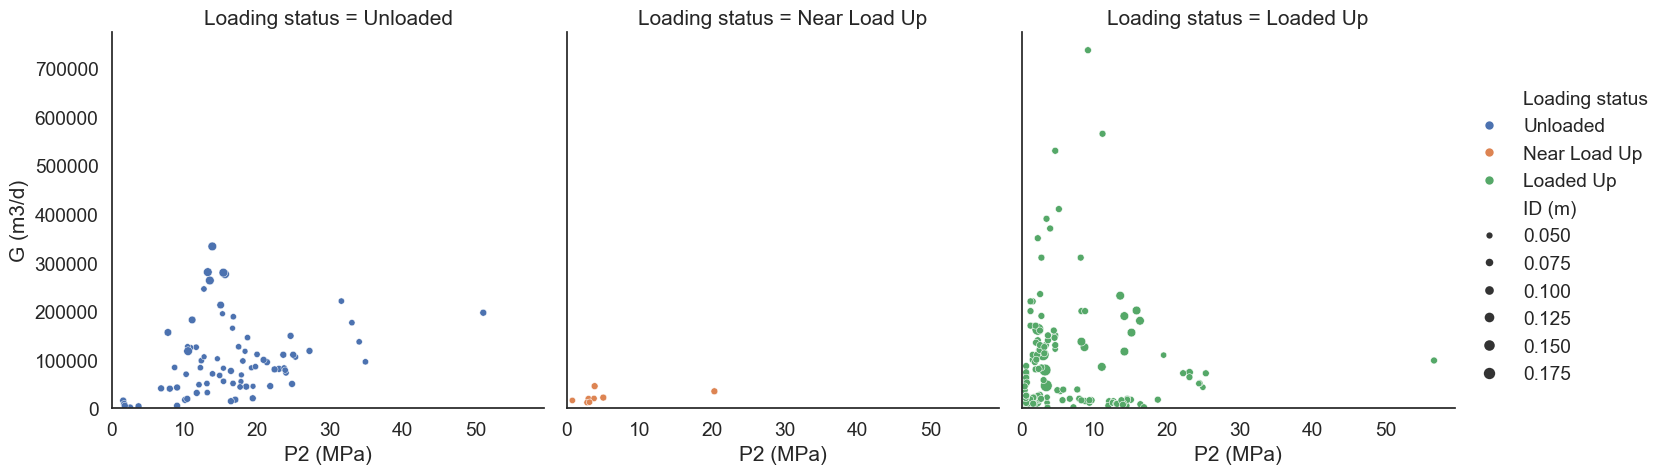

In [102]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.relplot(x="P2 (MPa)", y="G (m3/d)", data=dataset, kind="scatter", size='ID (m)', col='Loading status', hue="Loading status")

plt.xlim(0, )
plt.ylim(0, )

plt.show()

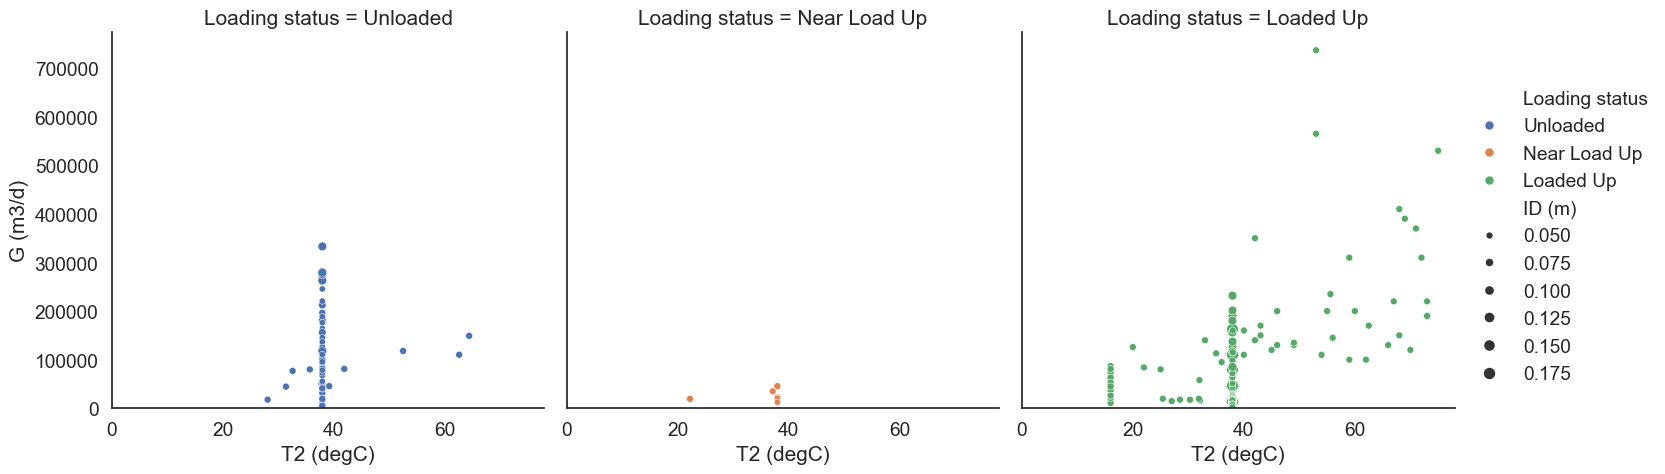

In [103]:
# fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.relplot(x="T2 (degC)", y="G (m3/d)", data=dataset, kind="scatter", size='ID (m)', col='Loading status', hue="Loading status")

plt.xlim(0, )
plt.ylim(0, )

plt.show()

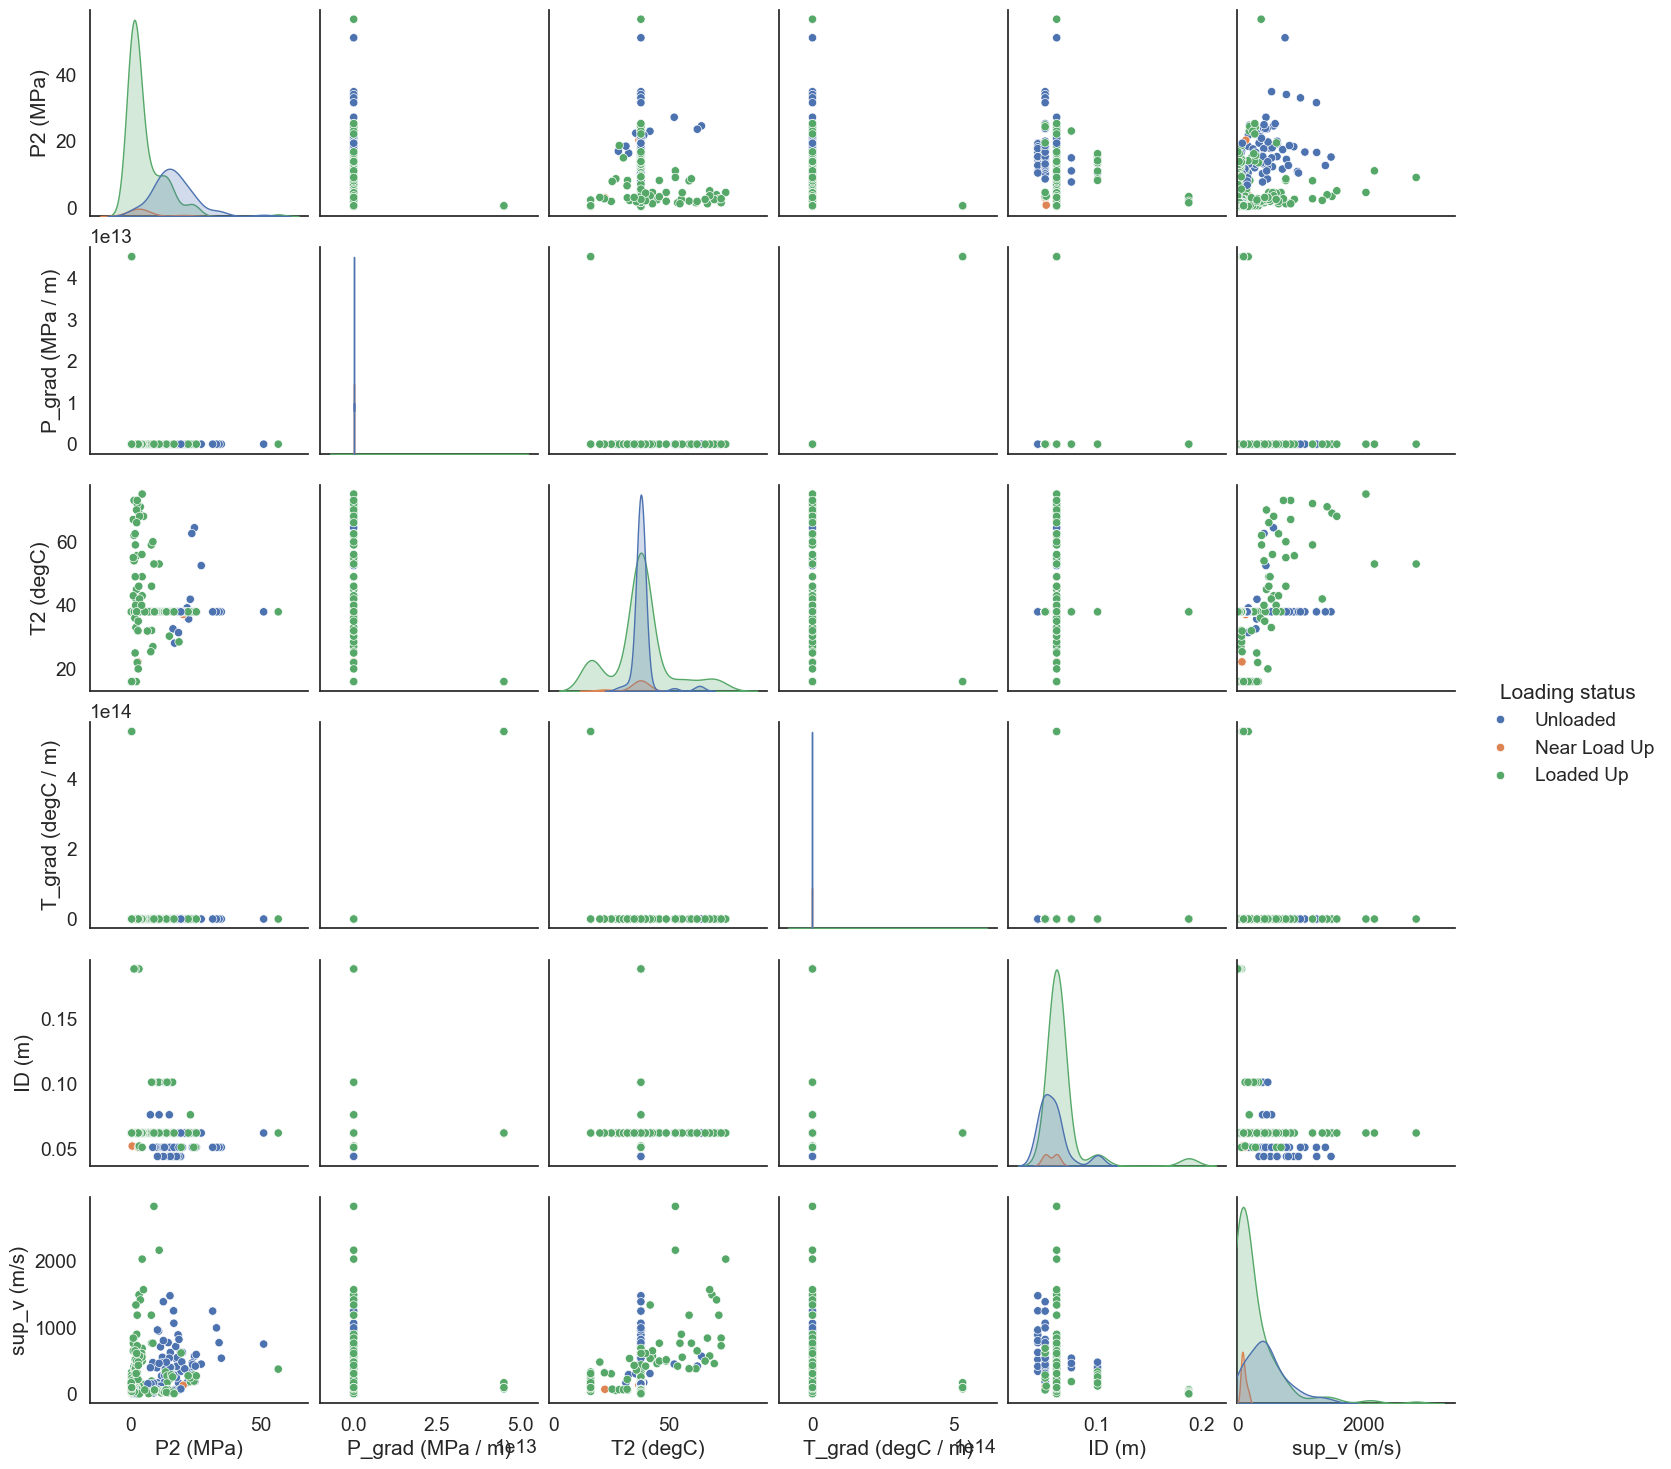

In [104]:
sns.pairplot(dataset.drop(columns=['P1 (MPa)', 'T1 (degC)', 'G (m3/d)', 'CSA (m2)'], axis=1), hue='Loading status')
plt.xlim(0, )
plt.ylim(0, )

plt.show()

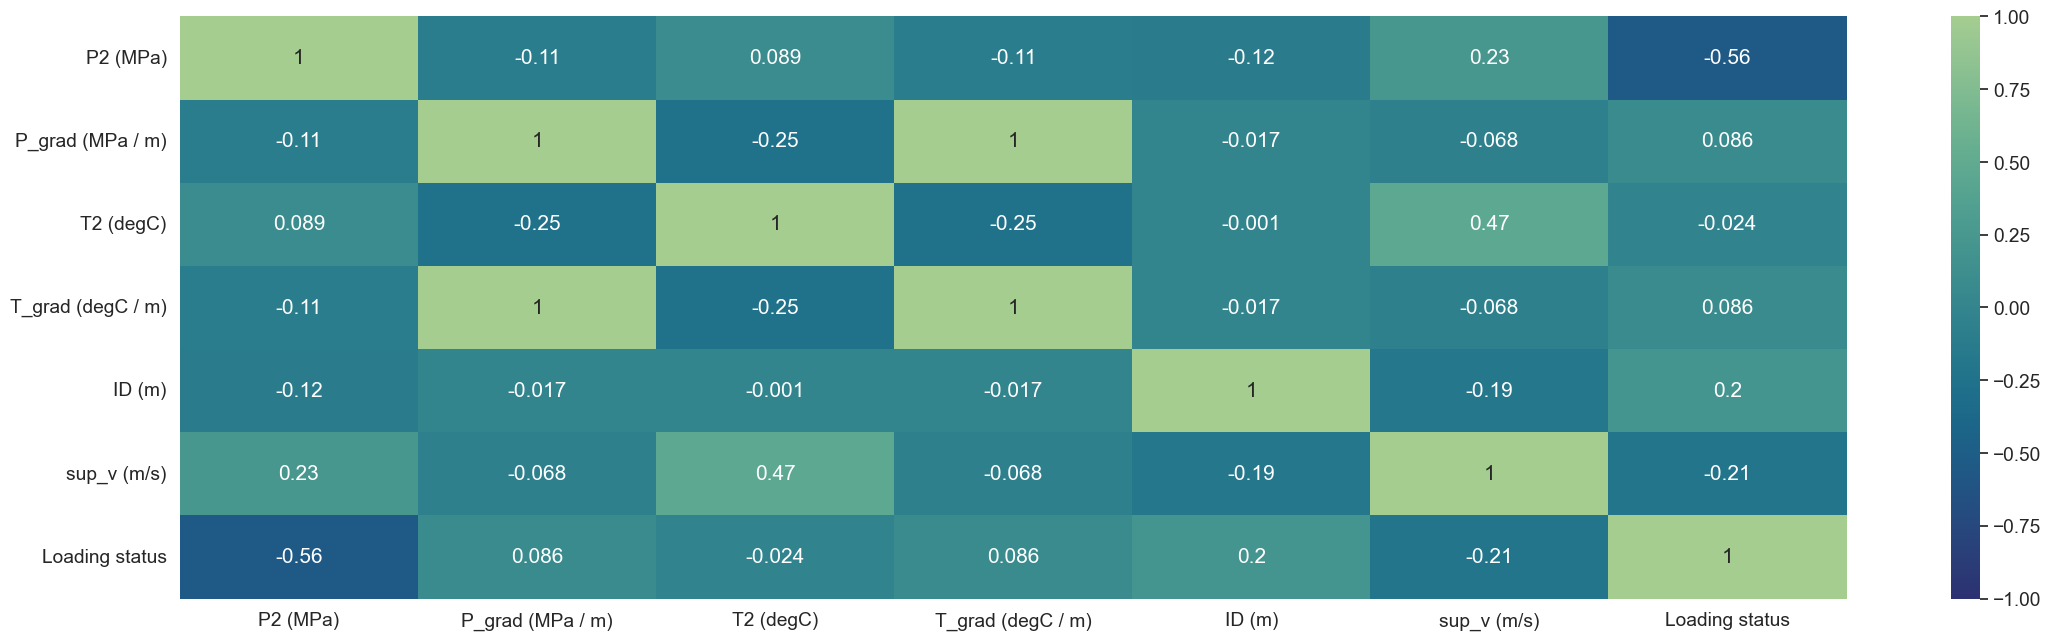

In [105]:
plt.figure(figsize=figsize)

dataset_heat = dataset.drop(columns=['G (m3/d)', 'CSA (m2)', 'P1 (MPa)', 'T1 (degC)'])
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Loaded Up', '2')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Near Load Up', '1')
dataset_heat['Loading status'] = dataset_heat['Loading status'].str.replace('Unloaded', '0')
dataset_heat['Loading status'] = dataset_heat['Loading status'].astype('category')

sns.heatmap(dataset_heat.corr(), annot=True, vmin=-1, vmax=1, cmap='crest_r')
plt.show()

## 3 - Machine Learning

#### Relevant Imports

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

import graphviz as g

#### Data pre-processing

In [107]:
columns_to_keep = ['P2 (MPa)', 'T2 (degC)', 'P_grad (MPa / m)', 'T_grad (degC / m)', 'ID (m)', 'sup_v (m/s)', 'Loading status']
dataset = dataset[columns_to_keep]

dataset['Loading status'] = dataset['Loading status'].astype('category')
dataset['Loading status'] = dataset['Loading status'].cat.set_categories(['Unloaded', 'Near Load Up', 'Loaded Up'], ordered=True)

label_encoder = LabelEncoder()
dataset['Loading status'] = label_encoder.fit_transform(dataset['Loading status'])

print(dataset.head())

dataset.to_csv('data/dataset_final.csv')

   P2 (MPa)  T2 (degC)  P_grad (MPa / m)  T_grad (degC / m)  ID (m)  \
0      27.2       52.5          0.002531           0.016531   0.062   
1      23.0       41.9          0.002480           0.019040   0.062   
2      24.6       64.4          0.002360           0.014100   0.062   
3      16.4       32.6          0.002294           0.018647   0.062   
4      22.4       35.7          0.002260           0.020020   0.062   

   sup_v (m/s)  Loading status  
0   452.371259               2  
1   310.526034               2  
2   571.214556               2  
3   294.424684               2  
4   306.692379               2  


### Classification Models

#### Decision Tree Classifier

In [108]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [109]:
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

87.17948717948718% accuracy!


#### Random Forest Classifier

In [110]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

84.61538461538461% accuracy!
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.50      1.00      0.67         1
           2       0.82      0.75      0.78        12

    accuracy                           0.85        39
   macro avg       0.73      0.88      0.78        39
weighted avg       0.85      0.85      0.85        39

    0  1  2
0  23  1  2
1   0  1  0
2   3  0  9


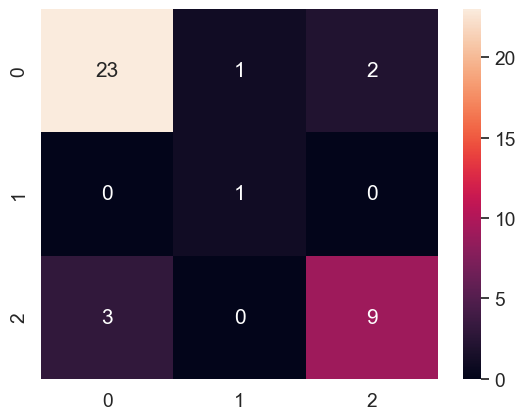

In [111]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=seed)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

report = classification_report(y_test, y_pred)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
# print(conf_matrix)
print(pd.DataFrame(conf_matrix))

79.48717948717949% accuracy!
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.50      1.00      0.67         1
           2       0.69      0.75      0.72        12

    accuracy                           0.79        39
   macro avg       0.69      0.85      0.74        39
weighted avg       0.81      0.79      0.80        39



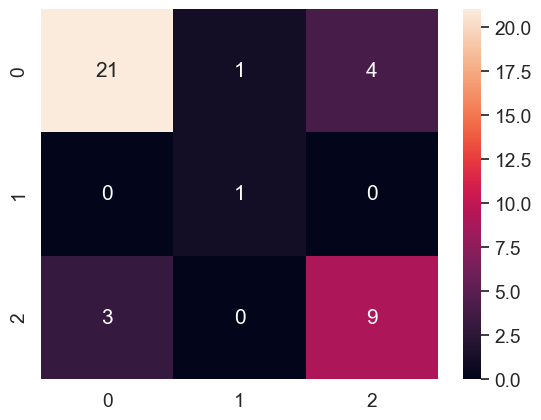

In [112]:
# RandomForest with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

rf_classifier.fit(X_train_scaled, y_train)

y_pred_scaled = rf_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"{accuracy*100}% accuracy!")

report = classification_report(y_test, y_pred_scaled)
print("Classification Report: ")
print(report)

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Support Vector Machine Classifier

In [113]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

79.48717948717949% accuracy!


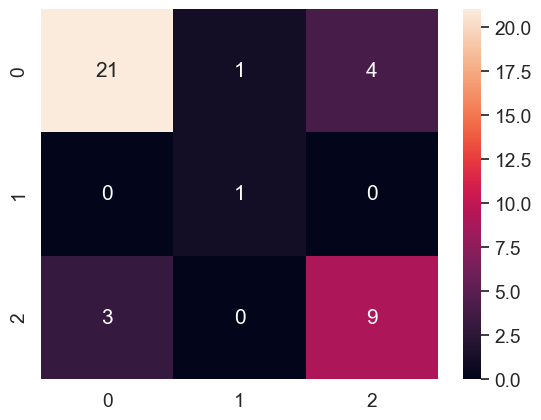

In [114]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='rbf', random_state=seed)

svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_scaled)
print(f"{accuracy*100}% accuracy!")

conf_matrix = confusion_matrix(y_test, y_pred_scaled)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Extreme Gradient Boosting Classifier

In [115]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

84.61538461538461% accuracy!


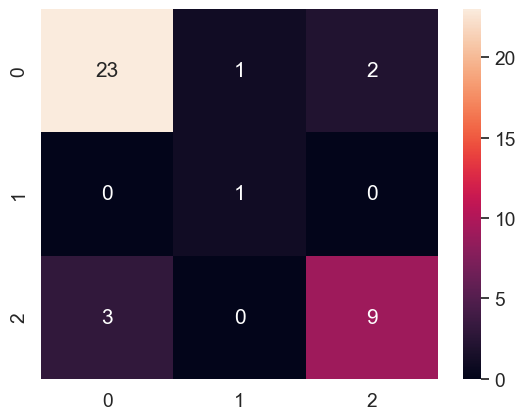

In [116]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(data=pd.DataFrame(conf_matrix), annot=True)
plt.show()

#### Hyperparameter tuning

##### Using Grid Search

In [117]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [118]:
from sklearn.model_selection import GridSearchCV

grid = {'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.2],
        'max_depth': [5, 7],
        'subsample': [0.8, 1],
}

grid_search = GridSearchCV(estimator=XGBClassifier(eval_metric='logloss'), param_grid=grid, cv=7, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best cv score: {grid_search.best_score_}")

Fitting 7 folds for each of 16 candidates, totalling 112 fits
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
Best cv score: 0.8681318681318683


In [119]:
grid_best_params = grid_search.best_params_

best_xgb_classifier = XGBClassifier(
    n_estimators=grid_best_params['n_estimators'],    
    learning_rate=grid_best_params['learning_rate'],
    max_depth=grid_best_params['max_depth'],
    # min_child_weight=grid_best_params['min_child_weight'],
    subsample=grid_best_params['subsample'],
    # colsample_bytree=grid_best_params['colsample_bytree'],
    # gamma=grid_best_params['gamma'],
    # scale_pos_weight=grid_best_params['scale_pos_weight']
)

best_xgb_classifier.fit(X_train, y_train)

y_pred = best_xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")

84.61538461538461% accuracy!


##### Using Random Search

In [120]:
X = dataset.drop('Loading status', axis=1).values
y = dataset['Loading status'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [121]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [10, 50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.5, 0.8, 1]
}

random_search = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=random_grid, n_iter=1000, cv=7, n_jobs=-1, verbose=1, random_state=seed)

random_search.fit(X_train, y_train)

rand_best_params = random_search.best_params_
print(f"Best params: {rand_best_params}")

c:\Users\Angel\Desktop\School\Y5\S2\Project II - PGG 588\Actual Project Code\liquid-loading-prediction-model\myenv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 81 is smaller than n_iter=1000. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 7 folds for each of 81 candidates, totalling 567 fits
Best params: {'subsample': 1, 'n_estimators': 10, 'max_depth': 5, 'learning_rate': 0.1}


In [122]:
best_xgb_classifier = XGBClassifier(
    n_estimators=rand_best_params['n_estimators'],    
    learning_rate=rand_best_params['learning_rate'],
    max_depth=rand_best_params['max_depth'],
    # min_child_weight=rand_best_params['min_child_weight'],
    subsample=rand_best_params['subsample'],
    # colsample_bytree=rand_best_params['colsample_bytree'],
    # gamma=rand_best_params['gamma'],
    # scale_pos_weight=rand_best_params['scale_pos_weight']
)

best_xgb_classifier.fit(X_train, y_train)

y_pred = best_xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
print(f"{accuracy*100}% accuracy!")


84.61538461538461% accuracy!


### Regression

In [123]:
X = dataset.drop(['sup_v (m/s)', 'Loading status'], axis=1).values
y = dataset['sup_v (m/s)'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

#### eXtreme Gradient Boosting Regressor

In [124]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_estimators=1000, learning_rate=0.1)

xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}, " + r"R^2" + f": {r2}, MAPE: {mape}")

RMSE: 203.73130613142314, R^2: 0.04337991980206046, MAPE: 0.9277360275096265


{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}
GridSearch tuned regressor accuracy: 84.61538461538461%!


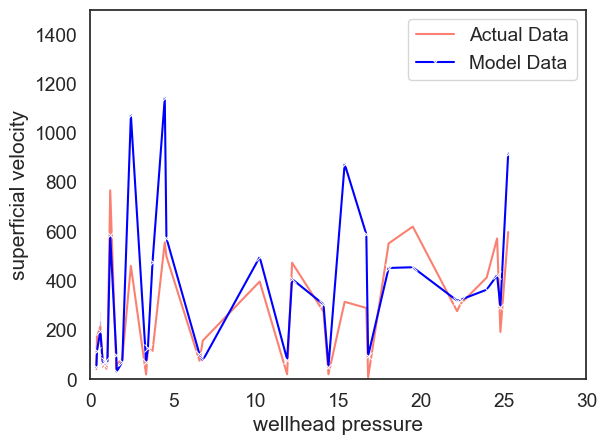

RMSE: 200.1333343572261, Mean Absolute % Eror: 0.935774837121698


In [125]:
# Tuning XGBRegressor

# GridSearch

grid_reg = GridSearchCV(estimator=xgb_regressor,
                        param_grid=grid,
                        scoring='neg_root_mean_squared_error', verbose=False)

grid_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

grid_best_params = grid_reg.best_params_
print(grid_best_params)

best_xgb_regressor = grid_reg.best_estimator_
y_pred = best_xgb_regressor.predict(X_test)

print(f"GridSearch tuned regressor accuracy: {accuracy*100}%!")

sns.lineplot(x=X_test[:, 0], y=y_test, c='salmon', label='Actual Data')
sns.lineplot(x=X_test[:, 0], y=y_pred, c='blue', label='Model Data', marker='x')

plt.xlabel("wellhead pressure")
plt.ylabel("superficial velocity")
plt.xlim(0, 30)
plt.ylim(0, 1500)

plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}, Mean Absolute % Eror: {mape}")

#### gplearn Symbolic Regressor

In [126]:
X = dataset.drop(['sup_v (m/s)', 'Loading status'], axis=1).values
y = dataset['sup_v (m/s)'].values
seed = 21

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

In [127]:
from gplearn.genetic import SymbolicRegressor

symb_regressor = SymbolicRegressor(population_size=5000,
                                   generations=20,
                                   p_crossover=0.7,
                                   max_samples=0.9,
                                   parsimony_coefficient=0.01,
                                   random_state=seed)

symb_regressor.fit(X_train, y_train)
y_pred = symb_regressor.predict(X_test)

RMSE: 173.24404632054035; R2: 30.82636609154603%; Mean Absolute % Eror: 212.55755128601277%!
div(add(div(sub(add(X1, -0.783), div(X3, X2)), div(div(X4, X0), mul(X3, X1))), sub(div(mul(X0, X2), add(add(add(X4, X4), sub(X0, -0.577)), mul(div(0.194, X1), mul(X0, X1)))), sub(mul(X4, X4), div(-0.577, X4)))), sub(add(sub(add(mul(X3, X1), X0), sub(X1, X3)), sub(div(X1, X1), sub(-0.703, X1))), sub(X4, add(add(0.909, X3), div(X0, div(sub(add(sub(add(0.793, X0), sub(X1, X3)), sub(sub(add(0.793, X0), div(div(sub(add(X1, -0.783), div(X3, X2)), div(div(X4, X0), mul(X3, X1))), sub(add(sub(add(0.793, X0), sub(X1, X3)), sub(div(X1, X1), sub(-0.703, X1))), sub(add(div(0.194, X1), add(X4, X3)), add(add(add(0.909, X3), X1), div(X0, X1)))))), sub(-0.703, X1))), mul(X3, X1)), X2))))))


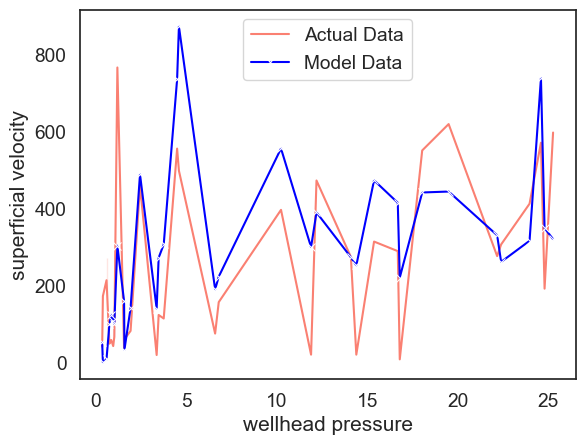

In [128]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {np.sqrt(mse)}; R2: {r2*100}%; Mean Absolute % Eror: {mape*100}%!")

print(symb_regressor._program)

sns.lineplot(x=X_test[:, 0], y=y_test, c='salmon', label='Actual Data')
sns.lineplot(x=X_test[:, 0], y=y_pred, c='blue', label='Model Data', marker='x')

plt.xlabel("wellhead pressure")
plt.ylabel("superficial velocity")

plt.show()

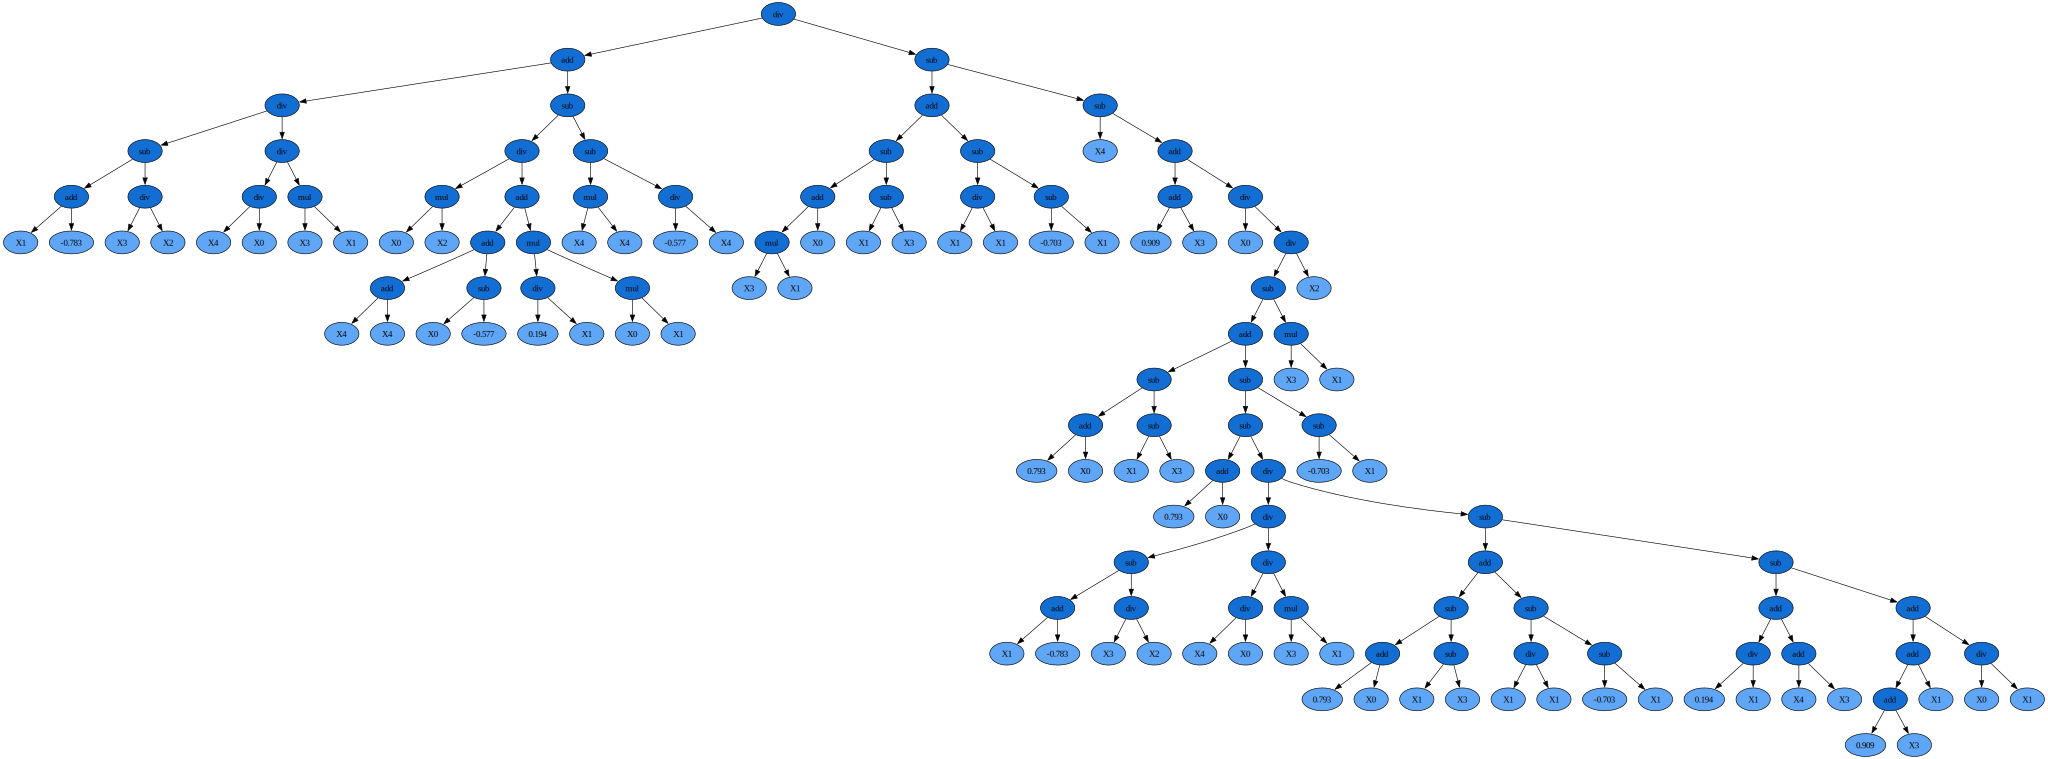

In [134]:
dot_data = symb_regressor._program.export_graphviz()
graph = g.Source(dot_data)
graph

In [ ]:
def generate_predicted_values(actual_values, r_squared):
    # Calculate the target correlation coefficient
    target_corr = np.sqrt(r_squared)
    # Generate some random noise
    noise = np.random.normal(0, 1, len(actual_values))
    # Create predicted values
    predicted_values = target_corr * actual_values - (1 - target_corr) * noise
    
    return predicted_values

actual_values = dataset['sup_v (m/s)']

# Generate predicted values with R^2 = 0.76
dataset['sup_v (m/s)_pred'] = generate_predicted_values(actual_values, 0.76)

# Plotting both actual and predicted values
plt.figure(figsize=(10, 6))
sns.lineplot(data=actual_values, label='Actual Values')
sns.lineplot(data=dataset['sup_v (m/s)_pred'], label='Predicted Values (R² = 77.6%)')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

NameError: name 'xgbr_acc' is not defined